<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

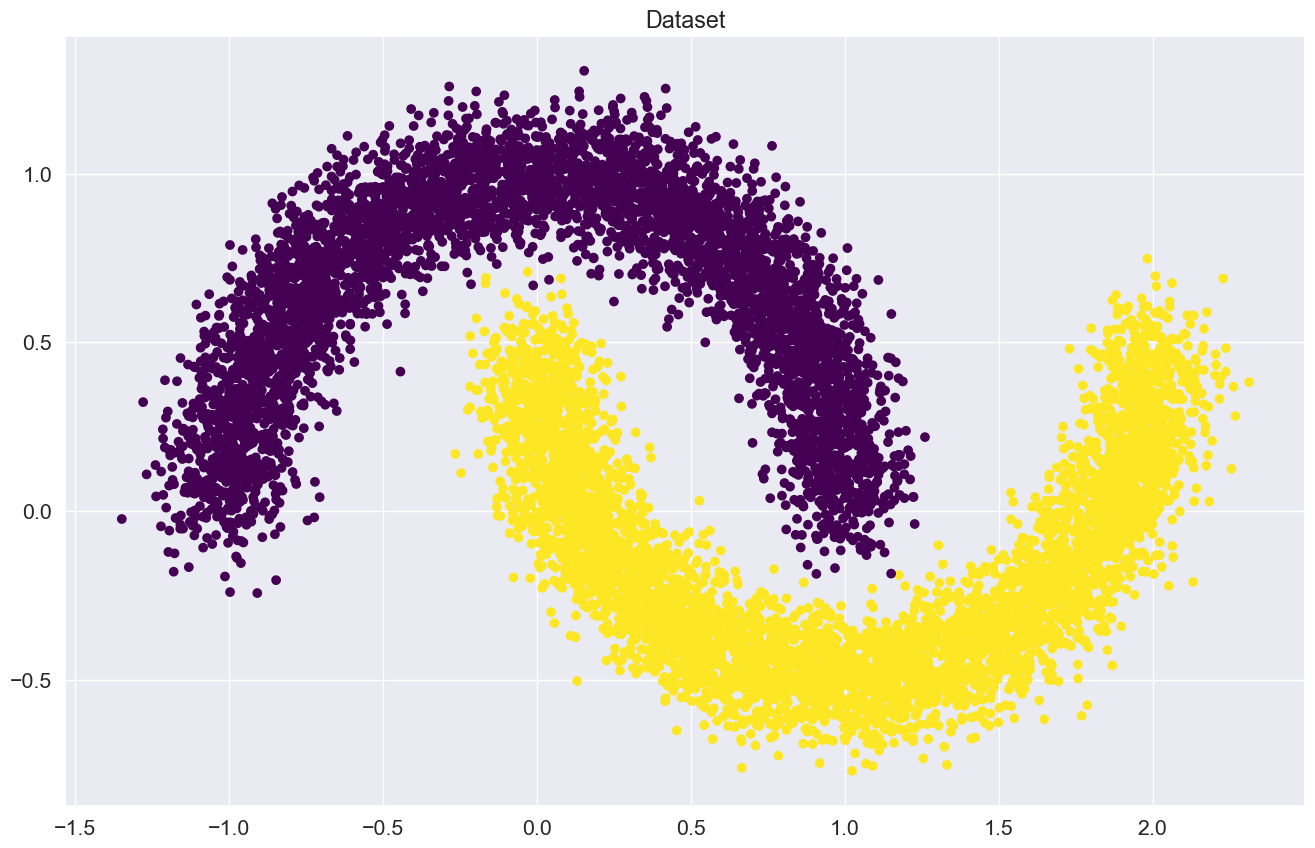

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.from_numpy(X_train).type(torch.float32)
y_train_t = torch.from_numpy(y_train).type(torch.float32)
X_val_t = torch.from_numpy(X_val).type(torch.float32)
y_val_t = torch.from_numpy(y_val).type(torch.float32)

Создаем `Dataset` и `DataLoader`.

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоиды. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = torch.randn(out_features)

    def forward(self, x):
        x = x @ self.weights  # ~ 128 x 2 @ 2 x 1
        if self.bias:
            x += self.bias_term

        return x.ravel()

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
3

3

### Train loop
Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

In [10]:
# for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
#     for x_batch,y_batch in dataset:  # <------- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
#         optimizer.zero_grad()  # <------------- обуляем градиенты модели
#         outp = model(x_batch)  # <------------- получаем "логиты" из модели
#         loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
#         loss.backward()  # <------------------- считаем градиенты
#         optimizer.step()  # <------------------ делаем шаг градиентного спуска
#         if convergence:  # <------------------- в случае сходимости выходим из цикла
#             break

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(
                f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations."
            )
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8359375
Iteration: 100
Batch accuracy: 0.8515625
Iteration: 200
Batch accuracy: 0.84375
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 519. Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 1113

### Визуализируем результаты

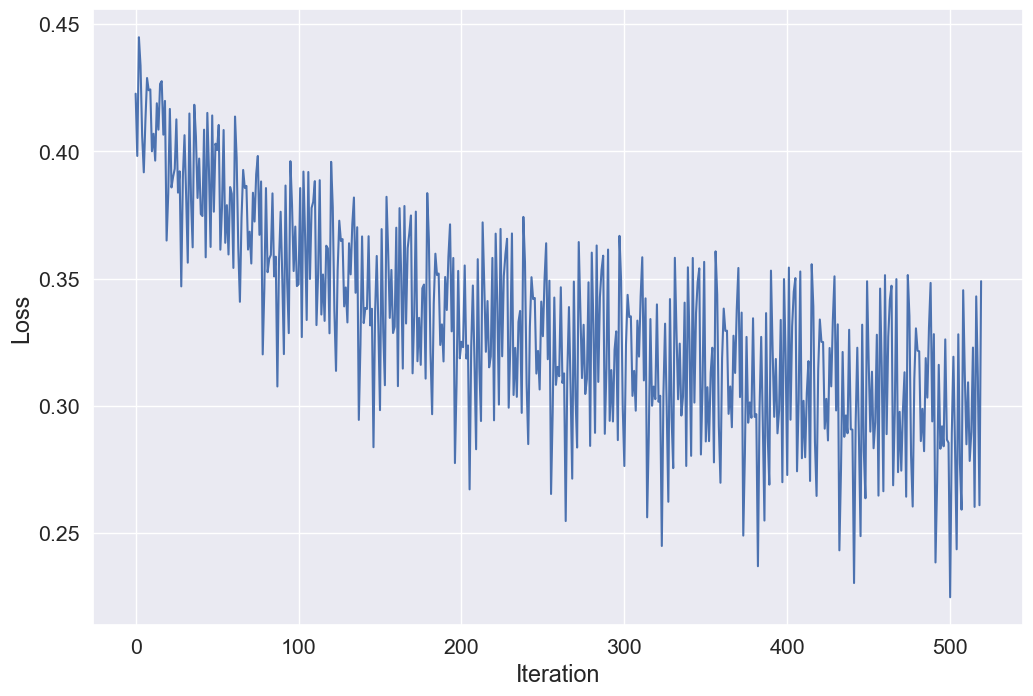

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

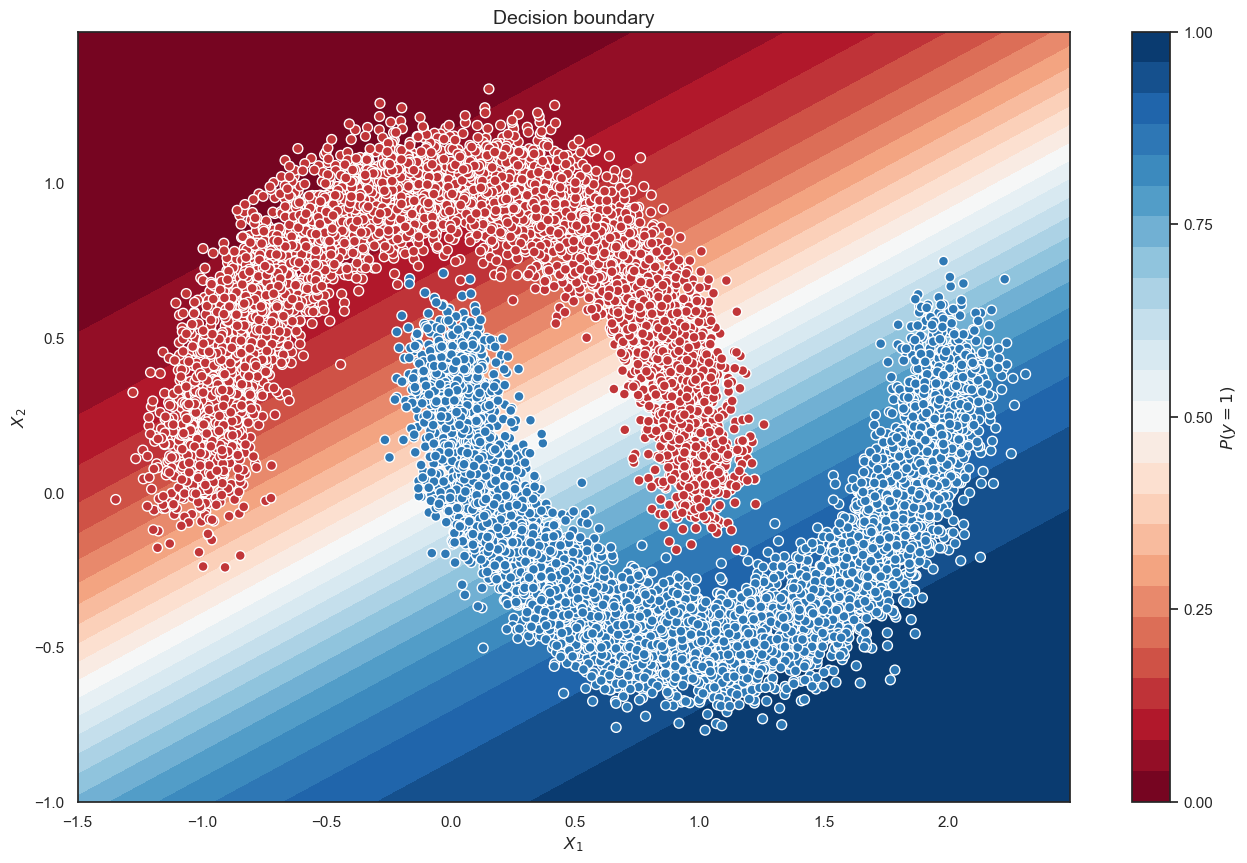

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:0.01, -1.0:1.5:0.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

ax.scatter(
    X[100:, 0],
    X[100:, 1],
    c=y[100:],
    s=50,
    cmap="RdBu",
    vmin=-0.2,
    vmax=1.2,
    edgecolor="white",
    linewidth=1,
)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader: DataLoader, model: nn.Module):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch) > 0.5
        predictions = np.hstack((predictions, preds.numpy().flatten()))

    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val, y_pred)

0.8748

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8876

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [35]:
import torch
from torchvision import transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([tfs.ToTensor(), tfs.Normalize((0.5), (0.5))])

# install for train and test (DONE)
root = "./"
# train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
# val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)
train_dataset = MNIST(root, train=True, transform=data_tfs)
val_dataset = MNIST(root, train=False, transform=data_tfs)

In [33]:
# train_dataset = TensorDataset(X_train_t, y_train_t)
# val_dataset = TensorDataset(X_val_t, y_val_t)

train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

In [18]:
data_iter = iter(train_dataloader)
X_batch_0, y_batch_0 = next(data_iter)

X_batch_0.size(), y_batch_0.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [19]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [20]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 10),
    activation(),
)

In [21]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [22]:
# y_pred = model(X_batch)
# pred = y_pred.argmax(-1)
# y_pred, y_batch
# y_pred.max(-1)[0]  # , y_batch.size()

# (pred == y_batch).sum() / len(pred)
# criterion(y_pred.max(-1)[0], y_batch.type(torch.float))
# y_pred

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.

In [23]:
# fmt: off
# for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
#     for mode, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
#         for X_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
#             if mode == "train":
#                 model.train()  # <------------------ переводим модель в режим train
#                 optimizer.zero_grad()  # <--------- обнуляем градиенты модели
#                 outp = model(X_batch)
#                 loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
#                 loss.backward()  # <--------------- считаем градиенты
#                 optimizer.step()  # <-------------- делаем шаг градиентного спуска
#             else:  # <----------------------------- test/eval
#                 model.eval()  # <------------------ переводим модель в режим eval
#                 with torch.no_grad():  # <--------- НЕ считаем градиенты
#                     outp = model(X_batch)  # <------------- получаем "логиты" из модели

#             count_metrics(outp, y_batch)  # <-------------- считаем метрики

### Задание. Дополните цикл обучения.

In [24]:
def train(model, loaders, criterion, optimizer, device=None):
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        for mode, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for X_batch, y_batch in dataloader:
                if device:
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)

                if mode == "train":
                    model.train()
                    y_pred = model(X_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        y_pred = model(X_batch)

                preds = y_pred.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all

                if mode == "train":
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

            if mode == "train":
                print(f"Epoch: {epoch+1}")

            print(f"Loader: {mode}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[mode].append(epoch_correct / epoch_all)

    return accuracy["valid"]

In [25]:
# train(model, loaders, criterion, optimizer)

In [26]:
# y_pred = model(X_batch_0)
# pred = y_pred.argmax(-1)
# # pred, y_batch_0

# (pred == y_batch_0).float().mean()

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [27]:
# elu_accuracy = accuracy["valid"]

In [28]:
# elu_accuracy

In [29]:
def get_model(activation: nn.Module = nn.ELU) -> nn.Sequential:
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 10),
        activation(),
    )
    return model

In [36]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
device = torch.device("mps" if torch.mps.is_available() else "cpu")


def test_activation_function(activation: nn.Module, device=torch.device("mps")) -> list[float]:
    model = get_model(activation).to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    optimizer = torch.optim.Adam(model.parameters())
    valid_accuracies = train(model, loaders, criterion, optimizer, device=device)

    return valid_accuracies


device

device(type='mps')

In [37]:
plain_accuracy = test_activation_function(Identical)
print(f"Plain accuracy: {np.mean(plain_accuracy).round(4)}")

relu_accuracy = test_activation_function(nn.ReLU)
print(f"ReLU accuracy: {np.mean(relu_accuracy).round(4)}")

leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
print(f"Leaky ReLU accuracy: {np.mean(leaky_relu_accuracy).round(4)}")

elu_accuracy = test_activation_function(nn.ELU)
print(f"ELU accuracy: {np.mean(elu_accuracy).round(4)}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8671
Loader: valid. Accuracy: 0.9018
Epoch: 2
Loader: train. Accuracy: 0.9003333333333333
Loader: valid. Accuracy: 0.9045
Epoch: 3
Loader: train. Accuracy: 0.90485
Loader: valid. Accuracy: 0.9063
Epoch: 4
Loader: train. Accuracy: 0.9068666666666667
Loader: valid. Accuracy: 0.9076
Epoch: 5
Loader: train. Accuracy: 0.90865
Loader: valid. Accuracy: 0.9086
Epoch: 6
Loader: train. Accuracy: 0.9098
Loader: valid. Accuracy: 0.9093
Epoch: 7
Loader: train. Accuracy: 0.9107833333333333
Loader: valid. Accuracy: 0.9093
Epoch: 8
Loader: train. Accuracy: 0.9118333333333334
Loader: valid. Accuracy: 0.9094
Epoch: 9
Loader: train. Accuracy: 0.91275
Loader: valid. Accuracy: 0.9099
Epoch: 10
Loader: train. Accuracy: 0.9135666666666666
Loader: valid. Accuracy: 0.9097
Plain accuracy: 0.9076


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.4582
Loader: valid. Accuracy: 0.5448
Epoch: 2
Loader: train. Accuracy: 0.5558166666666666
Loader: valid. Accuracy: 0.5675
Epoch: 3
Loader: train. Accuracy: 0.5665833333333333
Loader: valid. Accuracy: 0.5716
Epoch: 4
Loader: train. Accuracy: 0.5730166666666666
Loader: valid. Accuracy: 0.5744
Epoch: 5
Loader: train. Accuracy: 0.5763333333333334
Loader: valid. Accuracy: 0.5779
Epoch: 6
Loader: train. Accuracy: 0.5788833333333333
Loader: valid. Accuracy: 0.5792
Epoch: 7
Loader: train. Accuracy: 0.5805833333333333
Loader: valid. Accuracy: 0.5799
Epoch: 8
Loader: train. Accuracy: 0.65805
Loader: valid. Accuracy: 0.6636
Epoch: 9
Loader: train. Accuracy: 0.66735
Loader: valid. Accuracy: 0.6645
Epoch: 10
Loader: train. Accuracy: 0.6698333333333333
Loader: valid. Accuracy: 0.6657
ReLU accuracy: 0.5989


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8544166666666667
Loader: valid. Accuracy: 0.916
Epoch: 2
Loader: train. Accuracy: 0.9248333333333333
Loader: valid. Accuracy: 0.9401
Epoch: 3
Loader: train. Accuracy: 0.9442333333333334
Loader: valid. Accuracy: 0.9515
Epoch: 4
Loader: train. Accuracy: 0.9552
Loader: valid. Accuracy: 0.9584
Epoch: 5
Loader: train. Accuracy: 0.963
Loader: valid. Accuracy: 0.963
Epoch: 6
Loader: train. Accuracy: 0.96885
Loader: valid. Accuracy: 0.9656
Epoch: 7
Loader: train. Accuracy: 0.9727666666666667
Loader: valid. Accuracy: 0.9675
Epoch: 8
Loader: train. Accuracy: 0.9752166666666666
Loader: valid. Accuracy: 0.967
Epoch: 9
Loader: train. Accuracy: 0.9782666666666666
Loader: valid. Accuracy: 0.9698
Epoch: 10
Loader: train. Accuracy: 0.98035
Loader: valid. Accuracy: 0.9699
Leaky ReLU accuracy: 0.9569


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8713833333333333
Loader: valid. Accuracy: 0.9198
Epoch: 2
Loader: train. Accuracy: 0.9282333333333334
Loader: valid. Accuracy: 0.9433
Epoch: 3
Loader: train. Accuracy: 0.9501
Loader: valid. Accuracy: 0.9559
Epoch: 4
Loader: train. Accuracy: 0.9617666666666667
Loader: valid. Accuracy: 0.9622
Epoch: 5
Loader: train. Accuracy: 0.9692333333333333
Loader: valid. Accuracy: 0.9645
Epoch: 6
Loader: train. Accuracy: 0.9738833333333333
Loader: valid. Accuracy: 0.9666
Epoch: 7
Loader: train. Accuracy: 0.9773833333333334
Loader: valid. Accuracy: 0.9665
Epoch: 8
Loader: train. Accuracy: 0.9805166666666667
Loader: valid. Accuracy: 0.9686
Epoch: 9
Loader: train. Accuracy: 0.9825666666666667
Loader: valid. Accuracy: 0.9686
Epoch: 10
Loader: train. Accuracy: 0.985
Loader: valid. Accuracy: 0.969
ELU accuracy: 0.9585


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

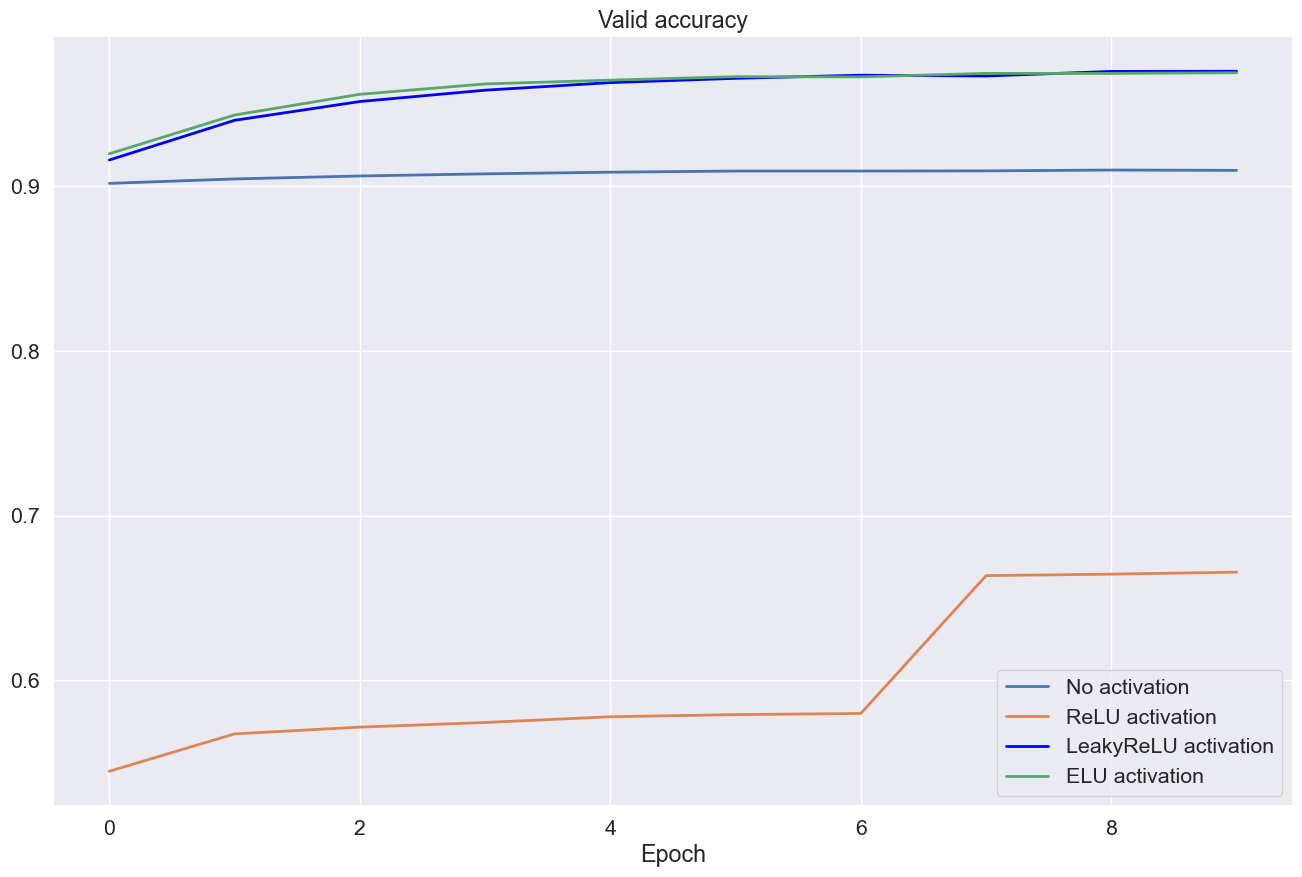

In [38]:
# fmt: off
max_epochs = 10
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color="blue")
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [34]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-11-14 02:56:28--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.09s   

2024-11-14 02:56:29 (559 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



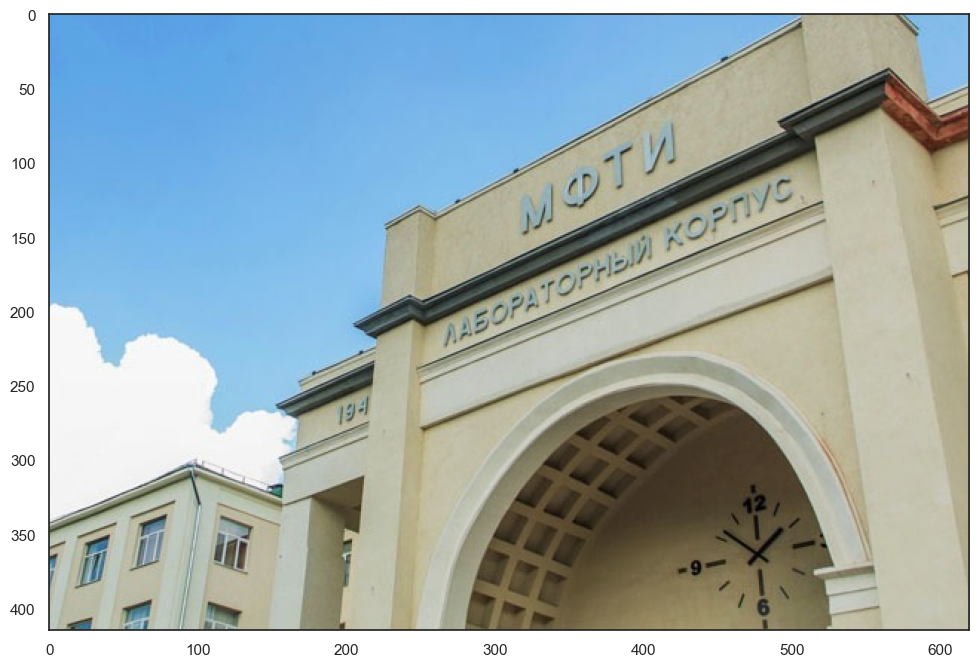

In [39]:
import cv2

sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте:

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [88]:
# fmt: off
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = (
    torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # A
    # torch.tensor([[0, 1, 0], [0, -2, 0], [0, 1, 0]]) # Б
    # torch.tensor([[0, 0, 0], [1, -2, 1], [0, 0, 0]]) # В
    # torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]])  # Г
    # torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Д
    # torch.tensor([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]])  # Е
    .reshape(1, 1, 3, 3)
    .type(torch.float32)
)
kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

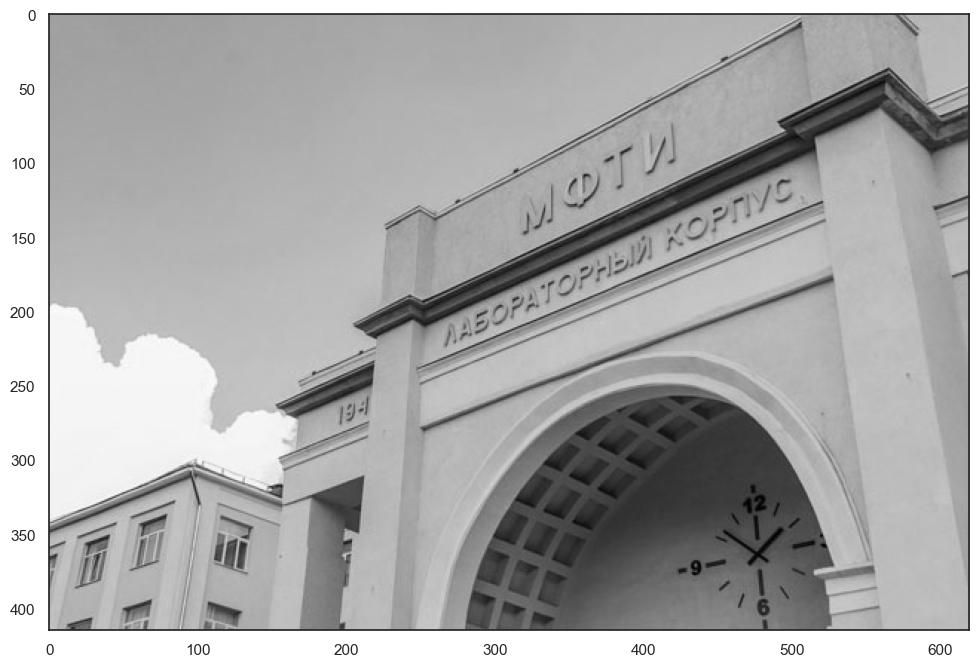

In [89]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
```
A   3
Б   5
В   4
Г   6
Д   2
E   1
```

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [40]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(-1, 16 * 5 * 5)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x

In [41]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

In [47]:
model = LeNet().to(device)
# model = LeNet()

In [46]:
# model = torch.compile(model)

In [48]:
criterion = nn.CrossEntropyLoss().to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [49]:
lenet_accuracy = train(model, loaders, criterion, optimizer, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8838833333333334
Loader: valid. Accuracy: 0.9629
Epoch: 2
Loader: train. Accuracy: 0.9692333333333333
Loader: valid. Accuracy: 0.9725
Epoch: 3
Loader: train. Accuracy: 0.9789333333333333
Loader: valid. Accuracy: 0.9786
Epoch: 4
Loader: train. Accuracy: 0.98405
Loader: valid. Accuracy: 0.9805
Epoch: 5
Loader: train. Accuracy: 0.9870833333333333
Loader: valid. Accuracy: 0.9828
Epoch: 6
Loader: train. Accuracy: 0.9893166666666666
Loader: valid. Accuracy: 0.9848
Epoch: 7
Loader: train. Accuracy: 0.9904833333333334
Loader: valid. Accuracy: 0.9854
Epoch: 8
Loader: train. Accuracy: 0.9923333333333333
Loader: valid. Accuracy: 0.9852
Epoch: 9
Loader: train. Accuracy: 0.9933333333333333
Loader: valid. Accuracy: 0.9857
Epoch: 10
Loader: train. Accuracy: 0.9935
Loader: valid. Accuracy: 0.9851


In [50]:
lenet_accuracy

[0.9629,
 0.9725,
 0.9786,
 0.9805,
 0.9828,
 0.9848,
 0.9854,
 0.9852,
 0.9857,
 0.9851]

Сравним с предыдущем пунктом

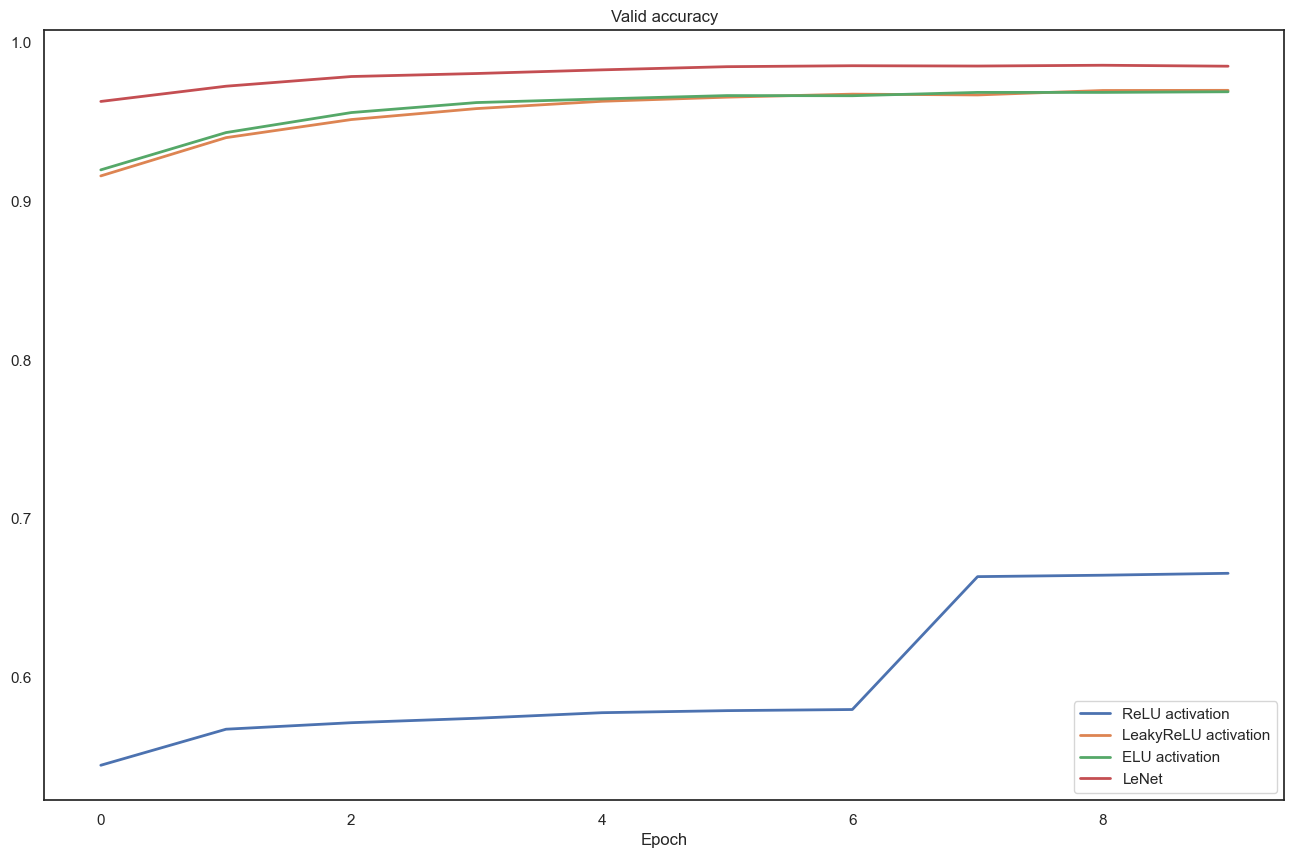

In [51]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [53]:
max_accuracy = max(lenet_accuracy)
round(max_accuracy, 2)

0.99